# Cache-Aware Prefetching Headroom Analysis

To study cache-aware prefetching, we wanted to know how we could reduce prefetcher traffic with information from the cache replacement policy. Recently, studies have shown that prefetchers can hinder performance by increasing memory traffic, especially in multi-core, multi-programmed workload settings. There has been related work in throttling prefetchers using local and global prefetcher performance feedback. We ask the question: Can we more accurately reduce unecessary / useless prefetches by using feedback from the cache replacement policy?

### Definitions

Prefetch: A prefetch request issued by the prefetcher, which could be a hit or miss in the cache

Prefetch fill: A prefetch that misses in the LLC, causing a prefetch fill request to DRAM

Useless Prefetch: A prefetch fill that is evicted without any Demand hits (Pm Ph* E)

Useful Prefetch: A prefetch fill that results in at least one Demand hit (Pm Ph* D)

k: the number of issued prefetches (miss or hit) before a Demand hit


### Headroom Studies
**Prefetch Interval Use**: The distribution of prefetch use inverals, defined as the following:

&nbsp;&nbsp;&nbsp;&nbsp; Pm - E

&nbsp;&nbsp;&nbsp;&nbsp; Ph - E

&nbsp;&nbsp;&nbsp;&nbsp; Pm - Ph

&nbsp;&nbsp;&nbsp;&nbsp; Ph - Ph

&nbsp;&nbsp;&nbsp;&nbsp; Pm - Dh

&nbsp;&nbsp;&nbsp;&nbsp; Ph - Dh

&nbsp;&nbsp;&nbsp;&nbsp; Pm - End of trace

&nbsp;&nbsp;&nbsp;&nbsp; Ph - End of trace

**Potential Prefetch Traffic Reduction**: The proportion of useless prefetches that can be potentially suppressed (Pm Ph* E intervals)

**k Distribution**

**k Predictability**: Measures of how predictable k is

**Timeliness of Last Prefetch (miss or hit) before Demand hit**:
**Accuracy of Prefetcher**

In [4]:
import sys, re
import matplotlib as mpl
import numpy as np
import os
import subprocess
import copy
mpl.rcParams['font.size'] = 14
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import argparse

In [ ]:
def get_experiment_traces(experiment, trace_list):
    for trace in trace_list:
    trace = trace[:-1]
    traces.append(trace)
    experiment_trace = '../current_output/'+experiment+'/'+trace+'.txt'
    experiment_trace_files.append(experiment_trace)
    return (experiment_trace_files, traces)

In [1]:
# helper functions
def graph_prefetch_use(experiment, experiment_trace_files, traces):
    (num_total_miss, num_total_prefetches, num_total_prefetch_fills_with_demand,
        percent_prefetch_fills_with_demand, 
        percent_prefetch_traffic_reduction_all, percent_prefetch_traffic_reduction_all_interval,
        percent_prefetch_miss_evict_interval, percent_prefetch_hit_evict_interval,
        percent_prefetch_miss_prefetch_hit, percent_prefetch_hit_prefetch_hit,
        percent_prefetch_miss_demand_hit, percent_prefetch_hit_demand_hit,
        percent_prefetch_miss_end_interval, percent_prefetch_hit_end_interval,
        num_total_prefetch_intervals, num_total_prefetch_fills)= search_prefetch(experiment_trace_files)
    
    percent_prefetches = [round(num_total_prefetches[i]/num_total_miss[i]*100.0, 2) for i in range(len(traces))]
    percent_prefetch_fills_with_demand = [round(i*100.0, 2) for i in percent_prefetch_fills_with_demand]
    percent_prefetch_traffic_reduction_all = [round(i*100.0, 2) for i in percent_prefetch_traffic_reduction_all]
    percent_prefetch_traffic_reduction_all_interval = [round(i*100.0, 2) for i in percent_prefetch_traffic_reduction_all_interval]
    percent_prefetch_miss_evict_interval = [round(i*100.0, 2) for i in percent_prefetch_miss_evict_interval]
    percent_prefetch_hit_evict_interval = [round(i*100.0, 2) for i in percent_prefetch_hit_evict_interval]
    percent_prefetch_miss_prefetch_hit = [round(i*100, 2) for i in percent_prefetch_miss_prefetch_hit]
    percent_prefetch_hit_prefetch_hit = [round(i*100.0, 2) for i in percent_prefetch_hit_prefetch_hit]
    percent_prefetch_miss_demand_hit = [round(i*100.0, 2) for i in percent_prefetch_miss_demand_hit]
    percent_prefetch_hit_demand_hit = [round(i*100, 2) for i in percent_prefetch_hit_demand_hit]
    percent_prefetch_miss_end_interval = [round(i*100.0, 2) for i in percent_prefetch_miss_end_interval]
    percent_prefetch_hit_end_interval = [round(i*100, 2) for i in percent_prefetch_hit_end_interval]
    percent_prefetch_fills = [round(num_total_prefetch_fills[i]/num_total_prefetch_intervals[i]*100.0, 2) if (num_total_prefetch_fills[i] > 0) else 0 for i in range(len(traces))]
    percent_prefetch_traffic_reduction_all_prefetch_intervals = [round(percent_prefetch_traffic_reduction_all[i]*percent_prefetch_fills[i]/100.0, 2) if (not np.isnan(percent_prefetch_traffic_reduction_all[i])) else 0 for i in range(len(traces))]
    percent_useful_prefetches = [round(1 - percent_prefetch_traffic_reduction_all_prefetch_intervals[i], 2) for i in range(len(traces))]
    
    percent_prefetches = add_mean(percent_prefetches)
    percent_prefetch_fills_with_demand = add_mean(percent_prefetch_fills_with_demand)
    percent_prefetch_traffic_reduction_all = add_mean(percent_prefetch_traffic_reduction_all)
    percent_prefetch_traffic_reduction_all_interval = add_mean(percent_prefetch_traffic_reduction_all_interval)
    percent_prefetch_miss_evict_interval = add_mean(percent_prefetch_miss_evict_interval)
    percent_prefetch_hit_evict_interval = add_mean(percent_prefetch_hit_evict_interval)
    percent_prefetch_miss_prefetch_hit = add_mean(percent_prefetch_miss_prefetch_hit)
    percent_prefetch_hit_prefetch_hit = add_mean(percent_prefetch_hit_prefetch_hit)
    percent_prefetch_miss_demand_hit = add_mean(percent_prefetch_miss_demand_hit)
    percent_prefetch_hit_demand_hit = add_mean(percent_prefetch_hit_demand_hit)
    percent_prefetch_miss_end_interval = add_mean(percent_prefetch_miss_end_interval)
    percent_prefetch_hit_end_interval = add_mean(percent_prefetch_hit_end_interval)
    percent_useful_prefetches = add_mean(percent_useful_prefetches)
    
    percent_prefetch_fills = add_mean(percent_prefetch_fills)
    percent_prefetch_traffic_reduction_all_prefetch_intervals = add_mean(percent_prefetch_traffic_reduction_all_prefetch_intervals)

    traces_with_mean = copy.deepcopy(traces)
    traces_with_mean.append('zz_mean')

    fig, ax = plt.subplots(2)
    bar = ax[0].bar(traces_with_mean, np.array(percent_prefetches), width = 0.5, label="percent prefetches")
    ax[0].set_ylabel("percent of accesses")
    add_data_labels(bar, ax[0], percent_prefetches)
    ax[0].set_xticks(np.arange(0, len(traces) + 1, 1))
    ax[0].set_xticklabels(traces_with_mean, rotation = 45, ha='right')

    # prefetch_reduction = np.array(percent_prefetch_traffic_reduction)
    bar1 = ax[1].bar(traces_with_mean, percent_prefetch_miss_evict_interval, width=0.5, label='percent_prefetch_miss_evict_interval')
    bar2 = ax[1].bar(traces_with_mean, percent_prefetch_hit_evict_interval, bottom= np.array(percent_prefetch_miss_evict_interval), width=0.5, label='percent_prefetch_hit_evict_interval')
    bar3 = ax[1].bar(traces_with_mean, percent_prefetch_miss_prefetch_hit, bottom= np.array(percent_prefetch_miss_evict_interval) + np.array(percent_prefetch_hit_evict_interval), width=0.5, label='percent_prefetch_miss_prefetch_hit_interval')
    bar4 = ax[1].bar(traces_with_mean, percent_prefetch_hit_prefetch_hit, bottom= np.array(percent_prefetch_miss_evict_interval) + np.array(percent_prefetch_hit_evict_interval) + np.array(percent_prefetch_miss_prefetch_hit), width=0.5, label='percent_prefetch_hit_prefetch_hit_interval')
    bar5 = ax[1].bar(traces_with_mean, percent_prefetch_miss_demand_hit, bottom= np.array(percent_prefetch_miss_evict_interval) + np.array(percent_prefetch_hit_evict_interval) + np.array(percent_prefetch_miss_prefetch_hit) + np.array(percent_prefetch_hit_prefetch_hit), width=0.5, label='percent_prefetch_miss_demand_hit_interval')
    bar6 = ax[1].bar(traces_with_mean, percent_prefetch_hit_demand_hit, bottom= np.array(percent_prefetch_miss_evict_interval) + np.array(percent_prefetch_hit_evict_interval) + np.array(percent_prefetch_miss_prefetch_hit) + np.array(percent_prefetch_hit_prefetch_hit) + np.array(percent_prefetch_miss_demand_hit), width=0.5, label='percent_prefetch_hit_demand_hit_interval')
    bar7 = ax[1].bar(traces_with_mean, percent_prefetch_miss_end_interval, bottom= np.array(percent_prefetch_miss_evict_interval) + np.array(percent_prefetch_hit_evict_interval) + np.array(percent_prefetch_miss_prefetch_hit) + np.array(percent_prefetch_hit_prefetch_hit) + np.array(percent_prefetch_miss_demand_hit) + np.array(percent_prefetch_hit_demand_hit), width=0.5, label='percent_prefetch_miss_end_interval')
    bar8 = ax[1].bar(traces_with_mean, percent_prefetch_hit_end_interval, bottom= np.array(percent_prefetch_miss_evict_interval) + np.array(percent_prefetch_hit_evict_interval) + np.array(percent_prefetch_miss_prefetch_hit) + np.array(percent_prefetch_hit_prefetch_hit) + np.array(percent_prefetch_miss_demand_hit) + np.array(percent_prefetch_hit_demand_hit) + np.array(percent_prefetch_miss_end_interval), width=0.5, label='percent_prefetch_hit_end_interval')
    ax[1].set_ylabel("percent of prefetches")
    add_data_labels(bar1, ax[1], percent_prefetch_miss_evict_interval)
    fig.set_figwidth(30)
    fig.set_figheight(30)
    ax[1].legend(loc = 'lower left')
    ax[0].set_title('percent of prefetch fills in all cache fills')
    ax[1].set_title('prefetch interval percentages')
    ax[0].set_ylim(bottom=0, top = 100)
    ax[1].set_ylim(bottom=0, top = 100)
    ax[1].set_xticks(np.arange(0, len(traces) + 1, 1))
    ax[1].set_xticklabels(traces_with_mean, rotation = 45, ha='right')
#     fig.suptitle(f'{experiment} prefetch intervals', fontsize=16)
    # plt.savefig(f'{experiment}_prefetch_intervals.png')
    

def graph_prefetch_traffic_reduction(experiment, experiment_trace_files, traces):
    (num_total_miss, num_total_prefetches, num_total_prefetch_fills_with_demand,
        percent_prefetch_fills_with_demand, 
        percent_prefetch_traffic_reduction_all, percent_prefetch_traffic_reduction_all_interval,
        percent_prefetch_miss_evict_interval, percent_prefetch_hit_evict_interval,
        percent_prefetch_miss_prefetch_hit, percent_prefetch_hit_prefetch_hit,
        percent_prefetch_miss_demand_hit, percent_prefetch_hit_demand_hit,
        percent_prefetch_miss_end_interval, percent_prefetch_hit_end_interval,
        num_total_prefetch_intervals, num_total_prefetch_fills)= search_prefetch(experiment_trace_files)
    percent_prefetches = [round(num_total_prefetches[i]/num_total_miss[i]*100.0, 2) for i in range(len(traces))]
    percent_prefetch_fills_with_demand = [round(i*100.0, 2) for i in percent_prefetch_fills_with_demand]
    percent_prefetch_traffic_reduction_all = [round(i*100.0, 2) for i in percent_prefetch_traffic_reduction_all]
    percent_prefetch_traffic_reduction_all_interval = [round(i*100.0, 2) for i in percent_prefetch_traffic_reduction_all_interval]
    percent_prefetch_miss_evict_interval = [round(i*100.0, 2) for i in percent_prefetch_miss_evict_interval]
    percent_prefetch_hit_evict_interval = [round(i*100.0, 2) for i in percent_prefetch_hit_evict_interval]
    percent_prefetch_miss_prefetch_hit = [round(i*100, 2) for i in percent_prefetch_miss_prefetch_hit]
    percent_prefetch_hit_prefetch_hit = [round(i*100.0, 2) for i in percent_prefetch_hit_prefetch_hit]
    percent_prefetch_miss_demand_hit = [round(i*100.0, 2) for i in percent_prefetch_miss_demand_hit]
    percent_prefetch_hit_demand_hit = [round(i*100, 2) for i in percent_prefetch_hit_demand_hit]
    percent_prefetch_miss_end_interval = [round(i*100.0, 2) for i in percent_prefetch_miss_end_interval]
    percent_prefetch_hit_end_interval = [round(i*100, 2) for i in percent_prefetch_hit_end_interval]
    percent_prefetch_fills = [round(num_total_prefetch_fills[i]/num_total_prefetch_intervals[i]*100.0, 2) if (num_total_prefetch_fills[i] > 0) else 0 for i in range(len(traces))]
    percent_prefetch_traffic_reduction_all_prefetch_intervals = [round(percent_prefetch_traffic_reduction_all[i]*percent_prefetch_fills[i]/100.0, 2) if (not np.isnan(percent_prefetch_traffic_reduction_all[i])) else 0 for i in range(len(traces))]
    percent_useful_prefetches = [round(100 - percent_prefetch_traffic_reduction_all_interval[i], 2) for i in range(len(traces))]
    percent_useful_prefetch_fills = [round(100 - percent_prefetch_traffic_reduction_all[i], 2) for i in range(len(traces))]

    # percent_useful_prefetches = [round(percent_useful_prefetches[i]*percent_prefetch_fills[i]/100.0, 2) if (not np.isnan(percent_useful_prefetches[i])) else 0 for i in range(len(traces))]
    percent_useful_prefetches_intervals = [round(percent_prefetch_miss_demand_hit[i] + percent_prefetch_hit_demand_hit[i], 2) for i in range(len(traces))]
    
    percent_prefetches = add_mean(percent_prefetches)
    percent_prefetch_fills_with_demand = add_mean(percent_prefetch_fills_with_demand)
    percent_prefetch_traffic_reduction_all = add_mean(percent_prefetch_traffic_reduction_all)
    percent_prefetch_traffic_reduction_all_interval = add_mean(percent_prefetch_traffic_reduction_all_interval)
    percent_prefetch_miss_evict_interval = add_mean(percent_prefetch_miss_evict_interval)
    percent_prefetch_hit_evict_interval = add_mean(percent_prefetch_hit_evict_interval)
    percent_prefetch_miss_prefetch_hit = add_mean(percent_prefetch_miss_prefetch_hit)
    percent_prefetch_hit_prefetch_hit = add_mean(percent_prefetch_hit_prefetch_hit)
    percent_prefetch_miss_demand_hit = add_mean(percent_prefetch_miss_demand_hit)
    percent_prefetch_hit_demand_hit = add_mean(percent_prefetch_hit_demand_hit)
    percent_prefetch_miss_end_interval = add_mean(percent_prefetch_miss_end_interval)
    percent_prefetch_hit_end_interval = add_mean(percent_prefetch_hit_end_interval)
    percent_useful_prefetches = add_mean(percent_useful_prefetches)
    percent_useful_prefetches_intervals = add_mean(percent_useful_prefetches_intervals)
    percent_useful_prefetch_fills = add_mean(percent_useful_prefetch_fills)

    
    percent_prefetch_fills = add_mean(percent_prefetch_fills)
    percent_prefetch_traffic_reduction_all_prefetch_intervals = add_mean(percent_prefetch_traffic_reduction_all_prefetch_intervals)

    traces_with_mean = copy.deepcopy(traces)
    traces_with_mean.append('zz_mean')
    fig, ax = plt.subplots(2)
    
    fig.set_figwidth(30)
    fig.set_figheight(30)
    

    bar = ax[0].bar(traces_with_mean, percent_prefetch_traffic_reduction_all, width = 0.5, label = 'prefetch traffic reduction')
    add_data_labels(bar, ax[0], percent_prefetch_traffic_reduction_all)
    bar1 = ax[0].bar(traces_with_mean, np.array(percent_useful_prefetch_fills), bottom = np.array(percent_prefetch_traffic_reduction_all), width=0.5, label='useful prefetches')
    bottom_heights = [rect.get_height() for rect in bar.patches]
    add_data_labels_stacked(bar1, ax[0], percent_useful_prefetch_fills, bottom_heights)
    ax[0].set_ylabel('percent of prefetch fills')
    ax[0].set_ylim(bottom=0, top = 100)
    ax[0].set_title('percent prefetch traffic reduction and useful prefetches out of all prefetch fills', y = 1.05)
    ax[0].set_xticks(np.arange(0, len(traces) + 1, 1))
    ax[0].set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    
    bar = ax[1].bar(traces_with_mean, percent_prefetch_fills, width = 0.5, color='gray')
    ax[1].set_ylabel('percent of prefetch intervals')
    ax[1].set_title('percent prefetch fills in all prefetch intervals')
    ax[1].set_ylim(bottom=0, top = 100)
    add_data_labels(bar, ax[1], percent_prefetch_fills)
    ax[1].set_xticks(np.arange(0, len(traces) + 1, 1))
    ax[1].set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    
    fig, ax = plt.subplots()
    
    fig.set_figwidth(30)
    fig.set_figheight(15)
    
    ind = np.arange(0, len(traces) + 1, 1)
    bar = ax.bar(ind, percent_prefetch_traffic_reduction_all_interval, width = 0.5, label = 'baseline')
    add_data_labels(bar, ax, percent_prefetch_traffic_reduction_all_interval)
    bar1 = ax.bar(traces_with_mean, np.array(percent_useful_prefetches), bottom = np.array(percent_prefetch_traffic_reduction_all_interval), width=0.5, label='useful prefetches')
    bottom_heights = [rect.get_height() for rect in bar.patches]
    add_data_labels_stacked(bar1, ax, percent_useful_prefetches, bottom_heights)
    ax.set_xticks(np.arange(0, len(traces) + 1, 1))
    ax.set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    ax.set_ylabel('percent of prefetch intervals')
    ax.set_title('percent prefetch traffic reduction out of all prefetch intervals', y=1.05)
    ax.set_ylim(bottom=0, top = 100)
#     fig.suptitle(f'{experiment} prefetch traffic reduction', fontsize=16)
    ax.set_xticks(np.arange(0, len(traces) + 1, 1))
    ax.set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    # plt.savefig(f'{experiment}_prefetch_traffic_reduction.png')
    
#     bar = ax[1].bar(ind, percent_useful_prefetches, width = 0.5)
#     ax[1].set_ylabel('Useful Prefetches')
#     add_data_labels(bar, ax[1], percent_useful_prefetches)
#     bar = ax[1].bar(ind+0.5, percent_useful_prefetches_intervals, width = 0.5)
#     add_data_labels(bar, ax[1], percent_useful_prefetches_intervals)
#     fig.set_figwidth(30)
#     fig.set_figheight(30)
#     ax[1].set_ylim(bottom=0, top = 100)
#     ax[1].set_title('Prefetcher Accuracy - Percent of Useful Prefetches out of all prefetch Intervals')
#     ax[1].set_xticks(np.arange(0, len(traces) + 1, 1))
#     ax[1].set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    
    
                                 

    
def search_prefetch(trace_files):
    percent_prefetch_traffic_reduction_all = []
    percent_prefetch_traffic_reduction_all_interval = []
    num_total_prefetches = []
    num_total_miss = []
    num_total_prefetch_fills_with_demand = []
    percent_prefetch_fills_with_demand = []

    percent_prefetch_miss_evict_interval = []
    percent_prefetch_hit_evict_interval = []
    percent_prefetch_miss_prefetch_hit = []
    percent_prefetch_hit_prefetch_hit = []
    percent_prefetch_miss_demand_hit = []
    percent_prefetch_hit_demand_hit = []
    percent_prefetch_miss_end_interval = []
    percent_prefetch_hit_end_interval = []
    num_total_prefetch_intervals = []
    num_total_prefetch_fills = []
    champsim_useful_prefetch = []
    for trace_file in trace_files:
        found = False
        count = [False] * 17
        for line in open(trace_file, 'r'):
            if (not count[0] and re.match('LLC TOTAL', line)):
                num_total_miss.append(float(line.split()[7]))
                count[0] = True
            elif (not count[1] and re.match('LLC PREFETCH  ACCESS:', line)):
                num_total_prefetches.append(float(line.split()[7]))
                count[1] = True
            elif not count[2] and re.match("num total prefetch fills with demand: ", line):
                num_total_prefetch_fills_with_demand.append(float(line.split()[6]))
                count[2] = True
            elif not count[3] and re.match("percent prefetch fills with demand: ", line):
                percent_prefetch_fills_with_demand.append(float(line.split()[5]))
                count[3] = True
            elif not count[5] and re.match("percent prefetch reduction traffic all interval: ", line):
                percent_prefetch_traffic_reduction_all_interval.append(float(line.split()[6]))
                count[5] = True
            elif not count[6] and re.match("percent prefetch_miss_evict_interval: ", line):
                percent_prefetch_miss_evict_interval.append(float(line.split()[2]))
                count[6] = True
            elif not count[7] and re.match("percent prefetch_hit_evict_interval: ", line):
                percent_prefetch_hit_evict_interval.append(float(line.split()[2]))
                count[7] = True
            elif not count[8] and re.match("percent prefetch_miss_prefetch_hit: ", line):
                percent_prefetch_miss_prefetch_hit.append(float(line.split()[2]))
                count[8] = True
            elif not count[9] and re.match("percent prefetch_hit_prefetch_hit: ", line):
                percent_prefetch_hit_prefetch_hit.append(float(line.split()[2]))
                count[9] = True
            elif not count[10] and re.match("percent prefetch_miss_demand_hit: ", line):
                percent_prefetch_miss_demand_hit.append(float(line.split()[2]))
                count[10] = True
            elif not count[11] and re.match("percent prefetch_hit_demand_hit: ", line):
                percent_prefetch_hit_demand_hit.append(float(line.split()[2]))
                count[11] = True
            elif not count[12] and re.match("percent prefetch_miss_end_interval: ", line):
                percent_prefetch_miss_end_interval.append(float(line.split()[2]))
                count[12] = True
            elif not count[13] and re.match("percent prefetch_hit_end_interval: ", line):
                percent_prefetch_hit_end_interval.append(float(line.split()[2]))
                count[13] = True
            elif not count[14] and re.match('percent prefetch reduction traffic all: ', line):
                percent_prefetch_traffic_reduction_all.append(float(line.split()[5]))
                count[14] = True
            elif not count[15] and re.match('num total prefetch intervals: ', line):
                num_total_prefetch_intervals.append(float(line.split()[4]))
                count[15] = True
            elif not count[16] and re.match('num total prefetch fills: ', line):
                num_total_prefetch_fills.append(float(line.split()[4]))
                count[16] = True
    return (num_total_miss, num_total_prefetches, num_total_prefetch_fills_with_demand,
        percent_prefetch_fills_with_demand, 
        percent_prefetch_traffic_reduction_all, percent_prefetch_traffic_reduction_all_interval,
        percent_prefetch_miss_evict_interval, percent_prefetch_hit_evict_interval,
        percent_prefetch_miss_prefetch_hit, percent_prefetch_hit_prefetch_hit,
        percent_prefetch_miss_demand_hit, percent_prefetch_hit_demand_hit,
        percent_prefetch_miss_end_interval, percent_prefetch_hit_end_interval, num_total_prefetch_intervals,
        num_total_prefetch_fills)

def add_data_labels(bar, ax, labels):
    rects = bar.patches
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
        
def add_data_labels_stacked(bar, ax,labels, bottom_heights):
    rects = bar.patches
    i = 0
    for rect, label in zip(rects, labels):
        height = rect.get_height() + bottom_heights[i]
        ax.text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
        i += 1
def mean(data):
    total = 0
    count = 0
    for x in data:
        if (not np.isnan(x)):
            total += x
        else:
            total += 0
        count += 1
    return  round(float(total/count), 2)
def add_mean(data):
    data.append(mean(data))
    return data

## Potential Prefetch Traffic Reduction

The study is done with the harmony and hawkeye cache replacement policy and the Best Offset and ISB prefetchers. Both the cache replacement policies and prefetchers are on the LLC. 

### Harmony with Best Offset Prefetch Interval Use Graph

Graph showing
1. **Percent of prefetch fills in all cache fills**: The proportion of LLC cache misses that are prefetch misses
2. **Prefetch Interval Percentages**: The proportions of each prefetch interval type for each benchmark

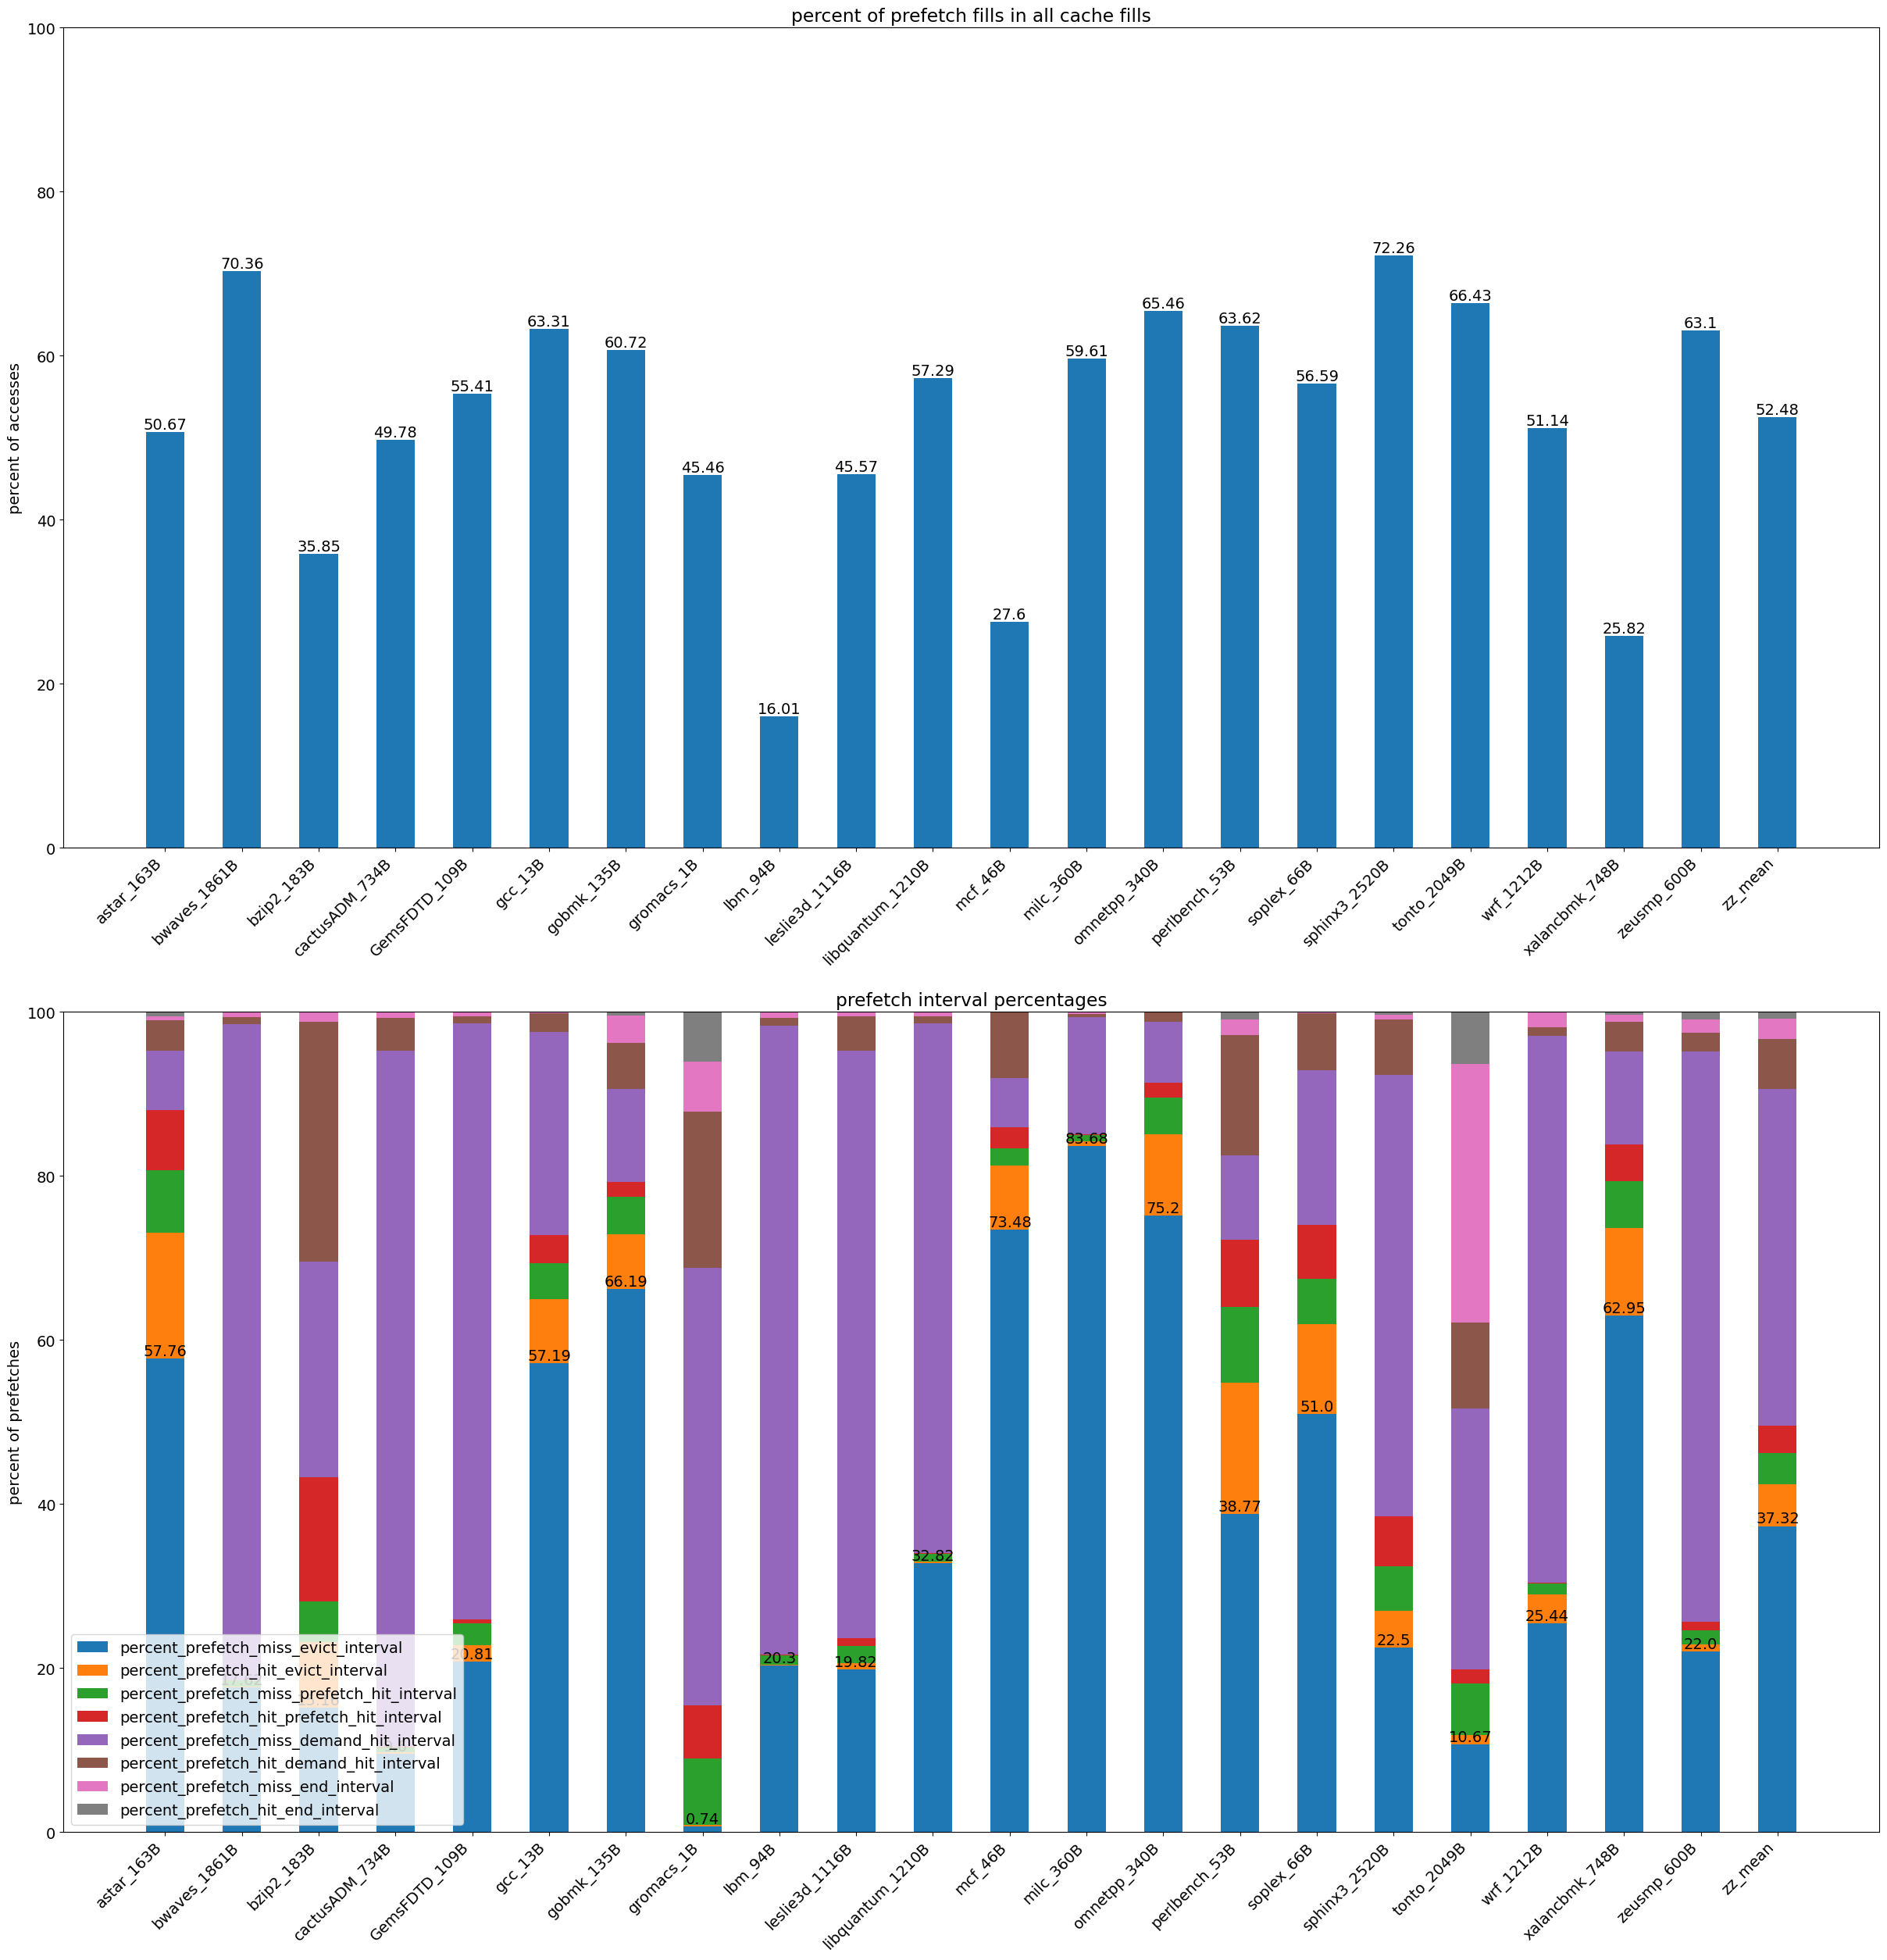

In [6]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_bo_updated_prefetch_traffic_interval'
trace_list = open('sim_list/traces.txt', 'r')

(experiment_trace_files, traces) = get_experiment_traces(experiment, trace_list)

graph_prefetch_use(experiment, experiment_trace_files, traces)
plt.show()

### Analysis

These results show significant headroom for reducing prefetch traffic, since the percent of Pm - E (blue bars on second graph) averages to about 37.32% on all benchmarks. The Pm - E intervals are all useless prefetches and represent the lower bound on the total amount of prefetch traffic reduction, which is defined as the amount of Pm - Ph* - E intervals. These results make sense because the Best Offset prefetcher is aggressive at a prefetch degree of 4. 


### Harmony with Best Offset Prefetch Traffic Reduction

Graph showing
1. **Percent prefetch traffic reduction and useful prefetches out of all prefetch fills**: The proportion of prefetch fills that are either useless prefetches (Pm Ph* E/end) intervals or useful prefetches (Pm Ph* Dh)
2. **Percent Prefetch Fills out of all prefetch intervals**: The proportion of intervals that begin with Pm (miss)
3. **Percent prefetch traffic reduction and useful prefetches out of all prefetch intervals**: Proportion of prefetch intervals that are useless prefetches (Pm/h Ph* E) or useful prefetches (Pm/h Ph* Dh). 

Note that the first and third graphs show stacked bars, where the bottom bars indicate the proportion of useless prefetches and the top bars indicate the proportion of useful prefetches. The first graph shows these proportions in terms of prefetch fills only, while the third graph shows these proportions in terms of all prefetch intervals (including intervals that start with prefetch hits). Prefetcher accuracy can be determined as the proportion of useful prefetches out of all prefetch intervals.

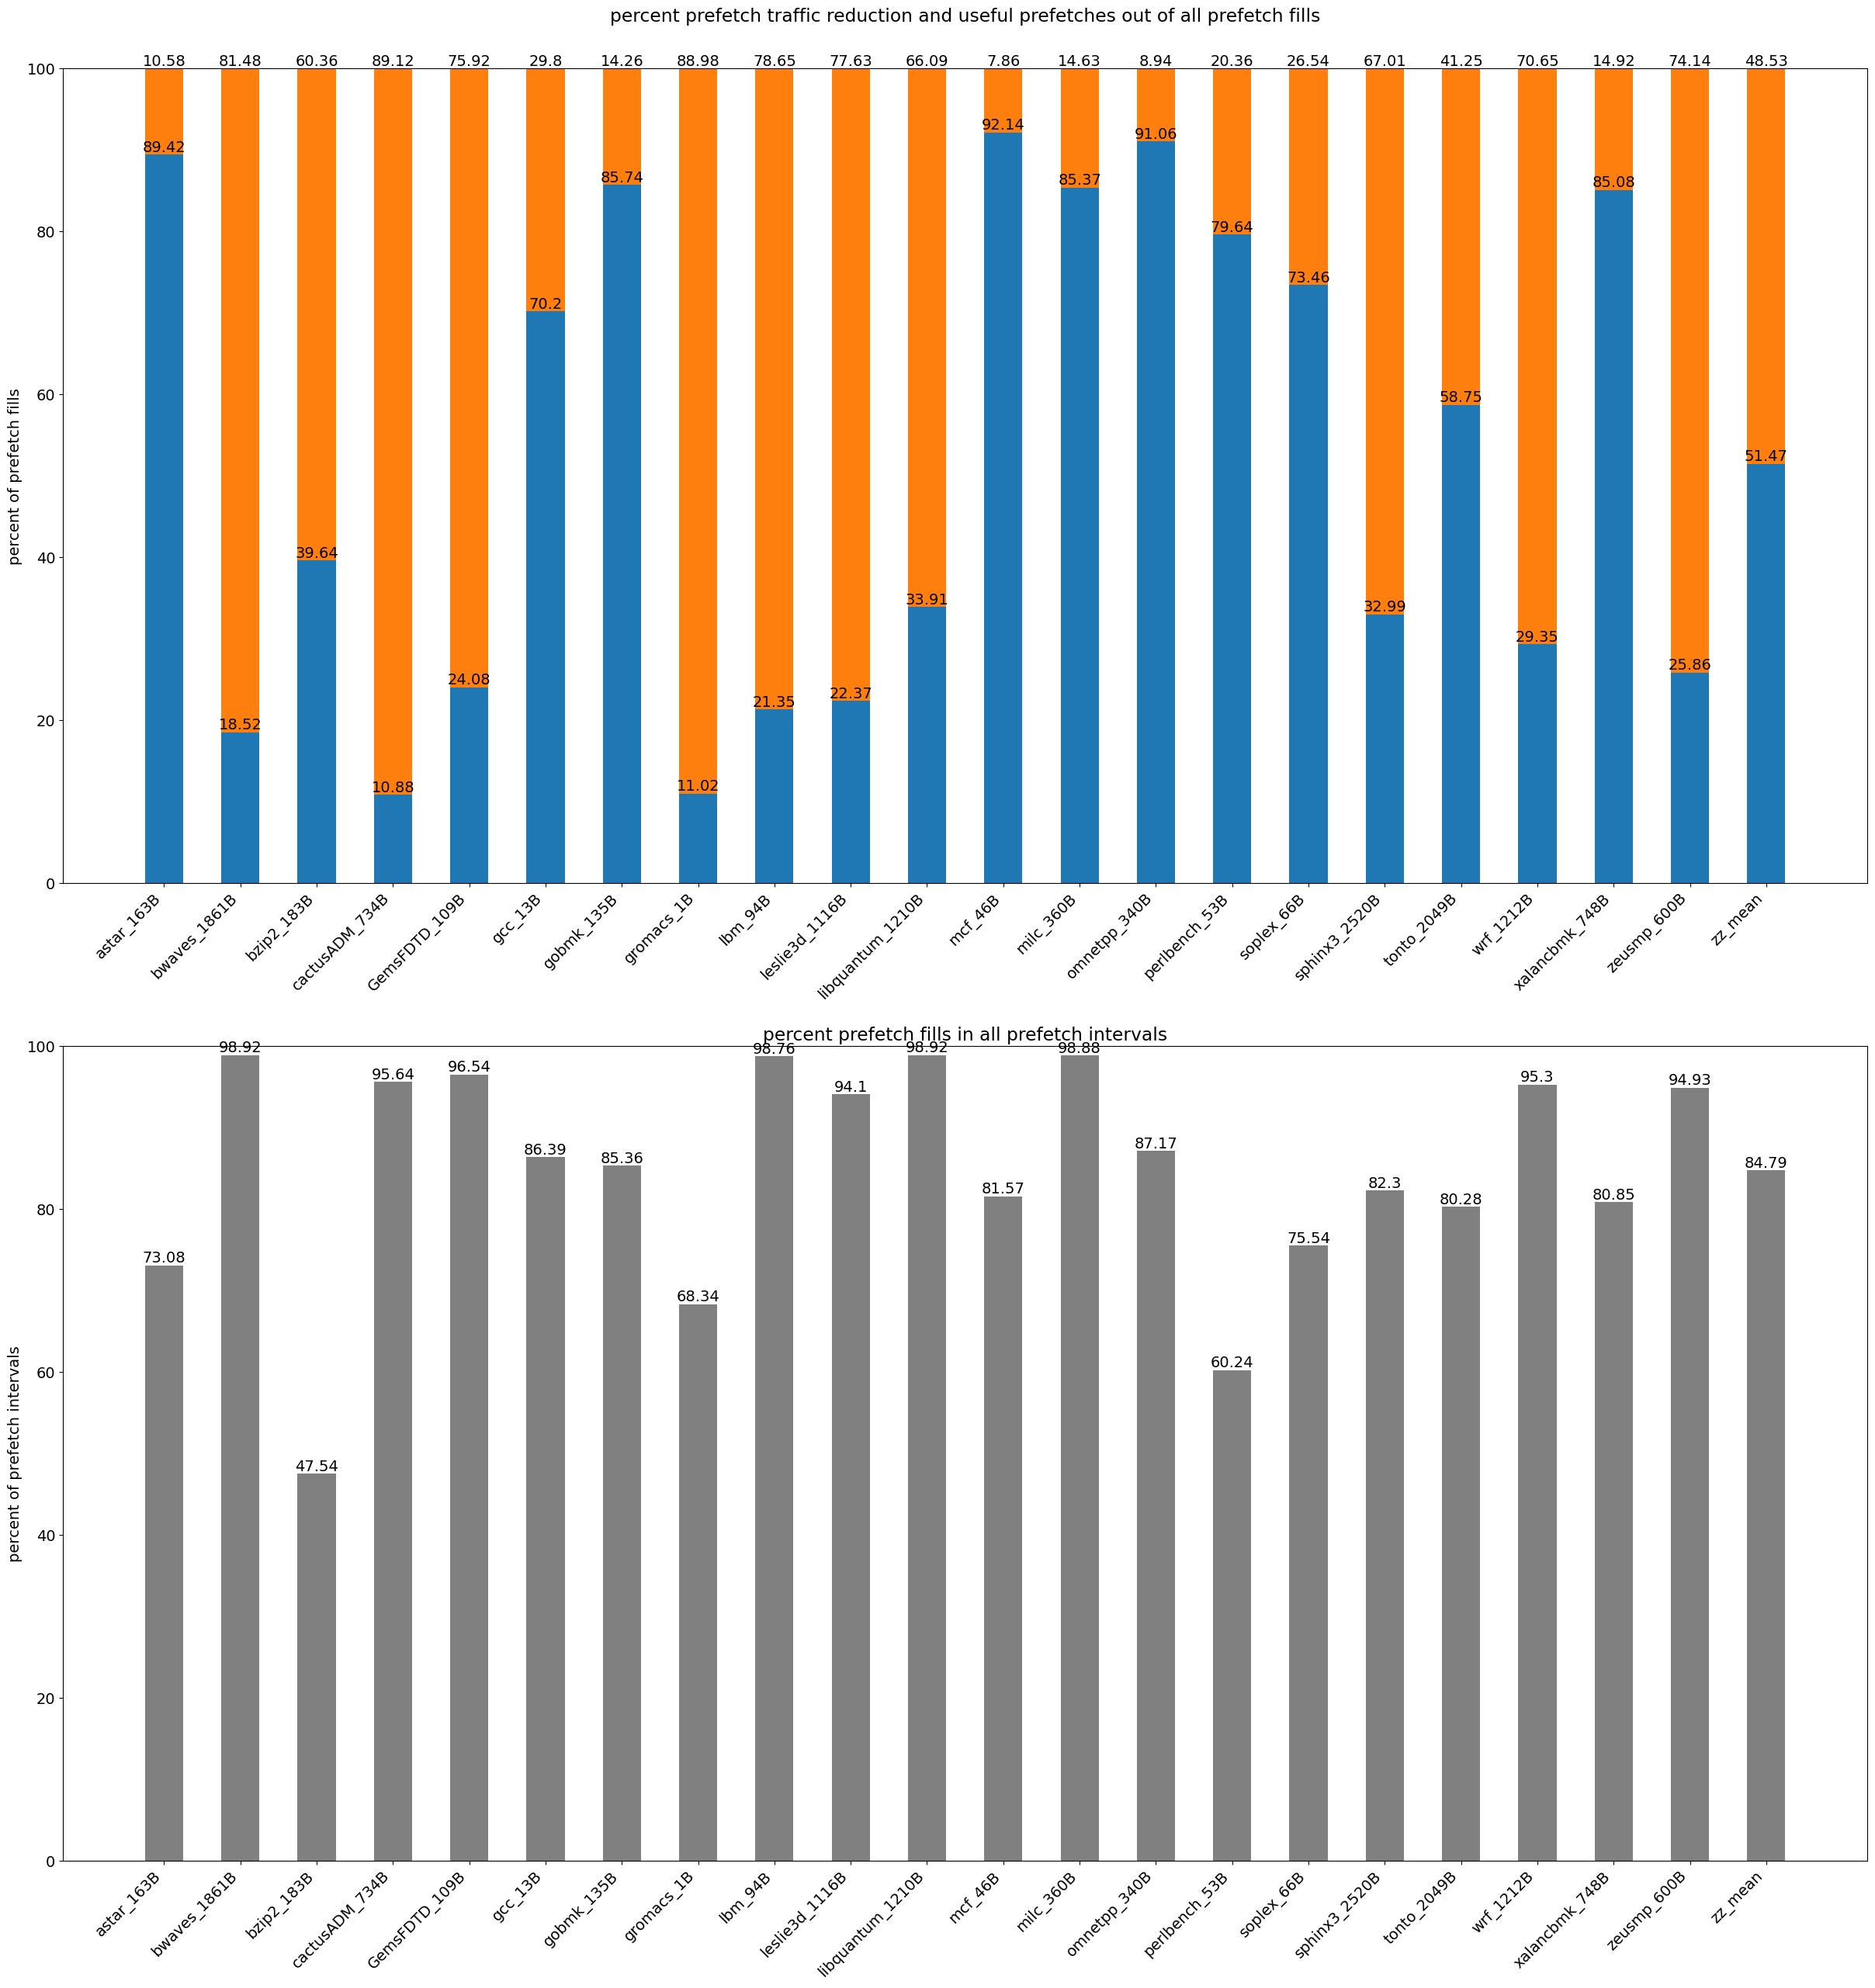

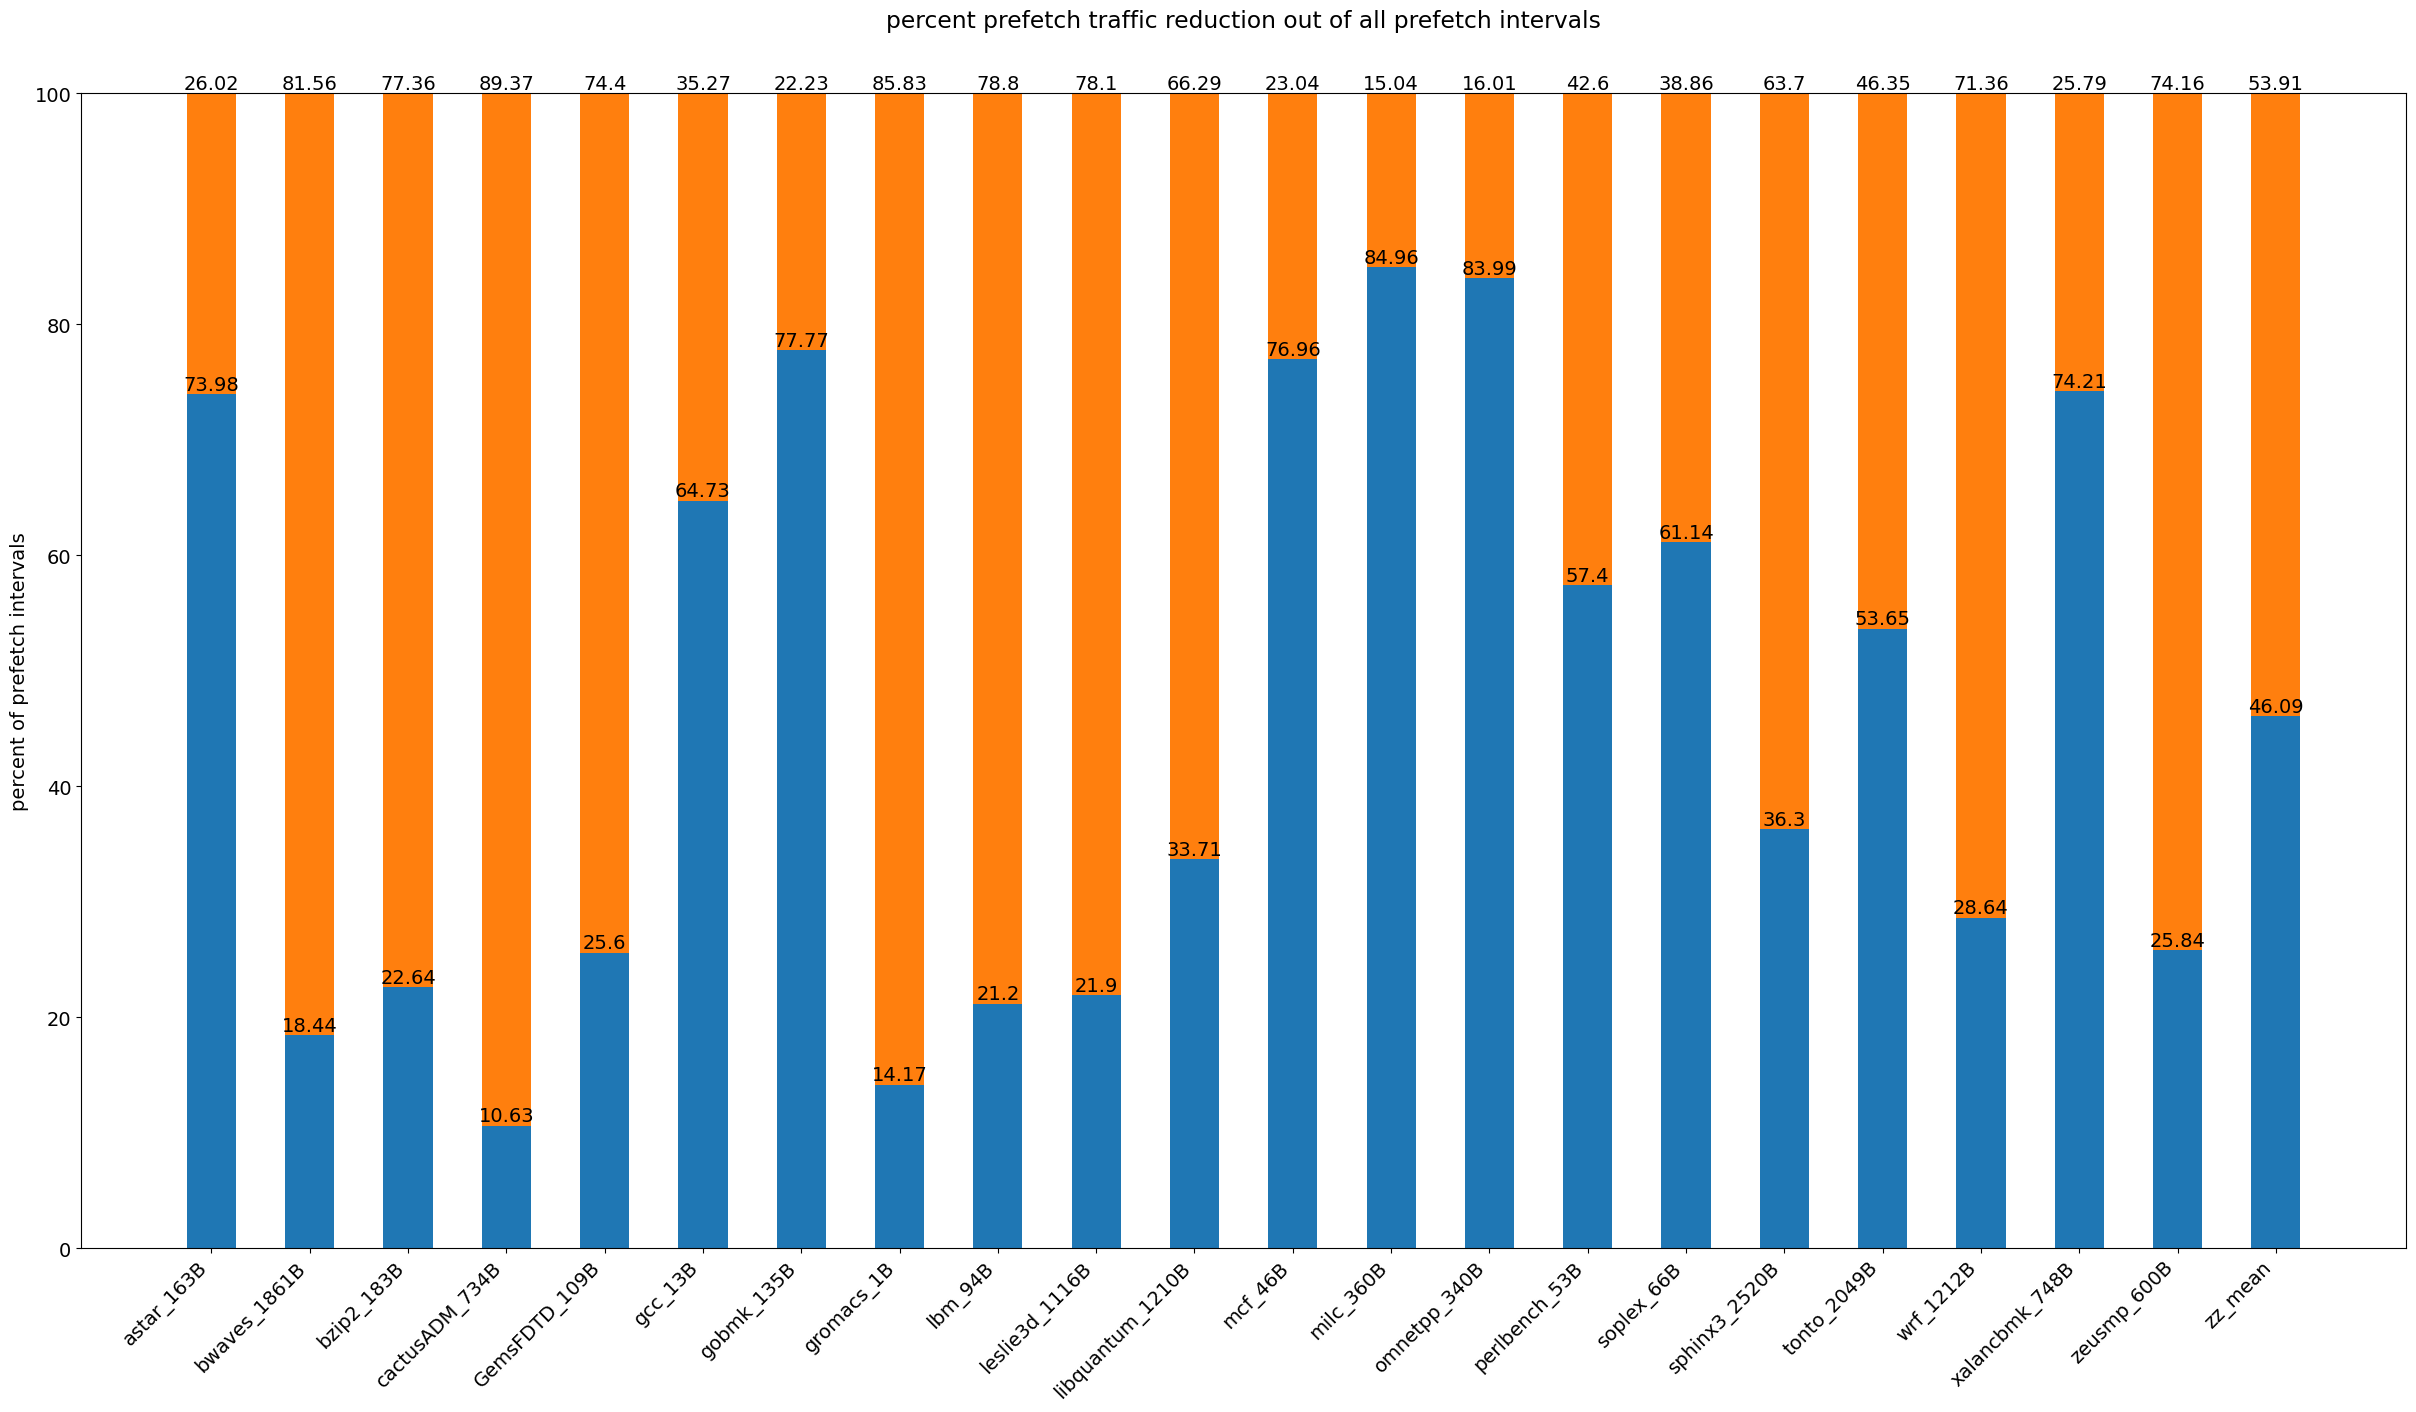

In [7]:
# Harmony with Best Offset Prefetch Traffic Reduction
graph_prefetch_traffic_reduction(experiment, experiment_trace_files, traces)
plt.show()

### Analysis

On average, about 51.47% of prefetch fills from the Best Offset prefetcher are useless prefetches. Furthermore, on average, 46.09% of prefetch intervals are useless prefetch intervals defined as the Pm/h - Ph* - E/end interval type, while 53.91% of all prefetch intervals are useful, defined as the Pm/h - Ph* - D interval type. From the percent of useful prefetch intervals, we can conclude that the Best Offset prefetcher with degree 4 is about 53.91% accurate in all issued prefetches.

### Harmony with ISB Prefetch Interval Use

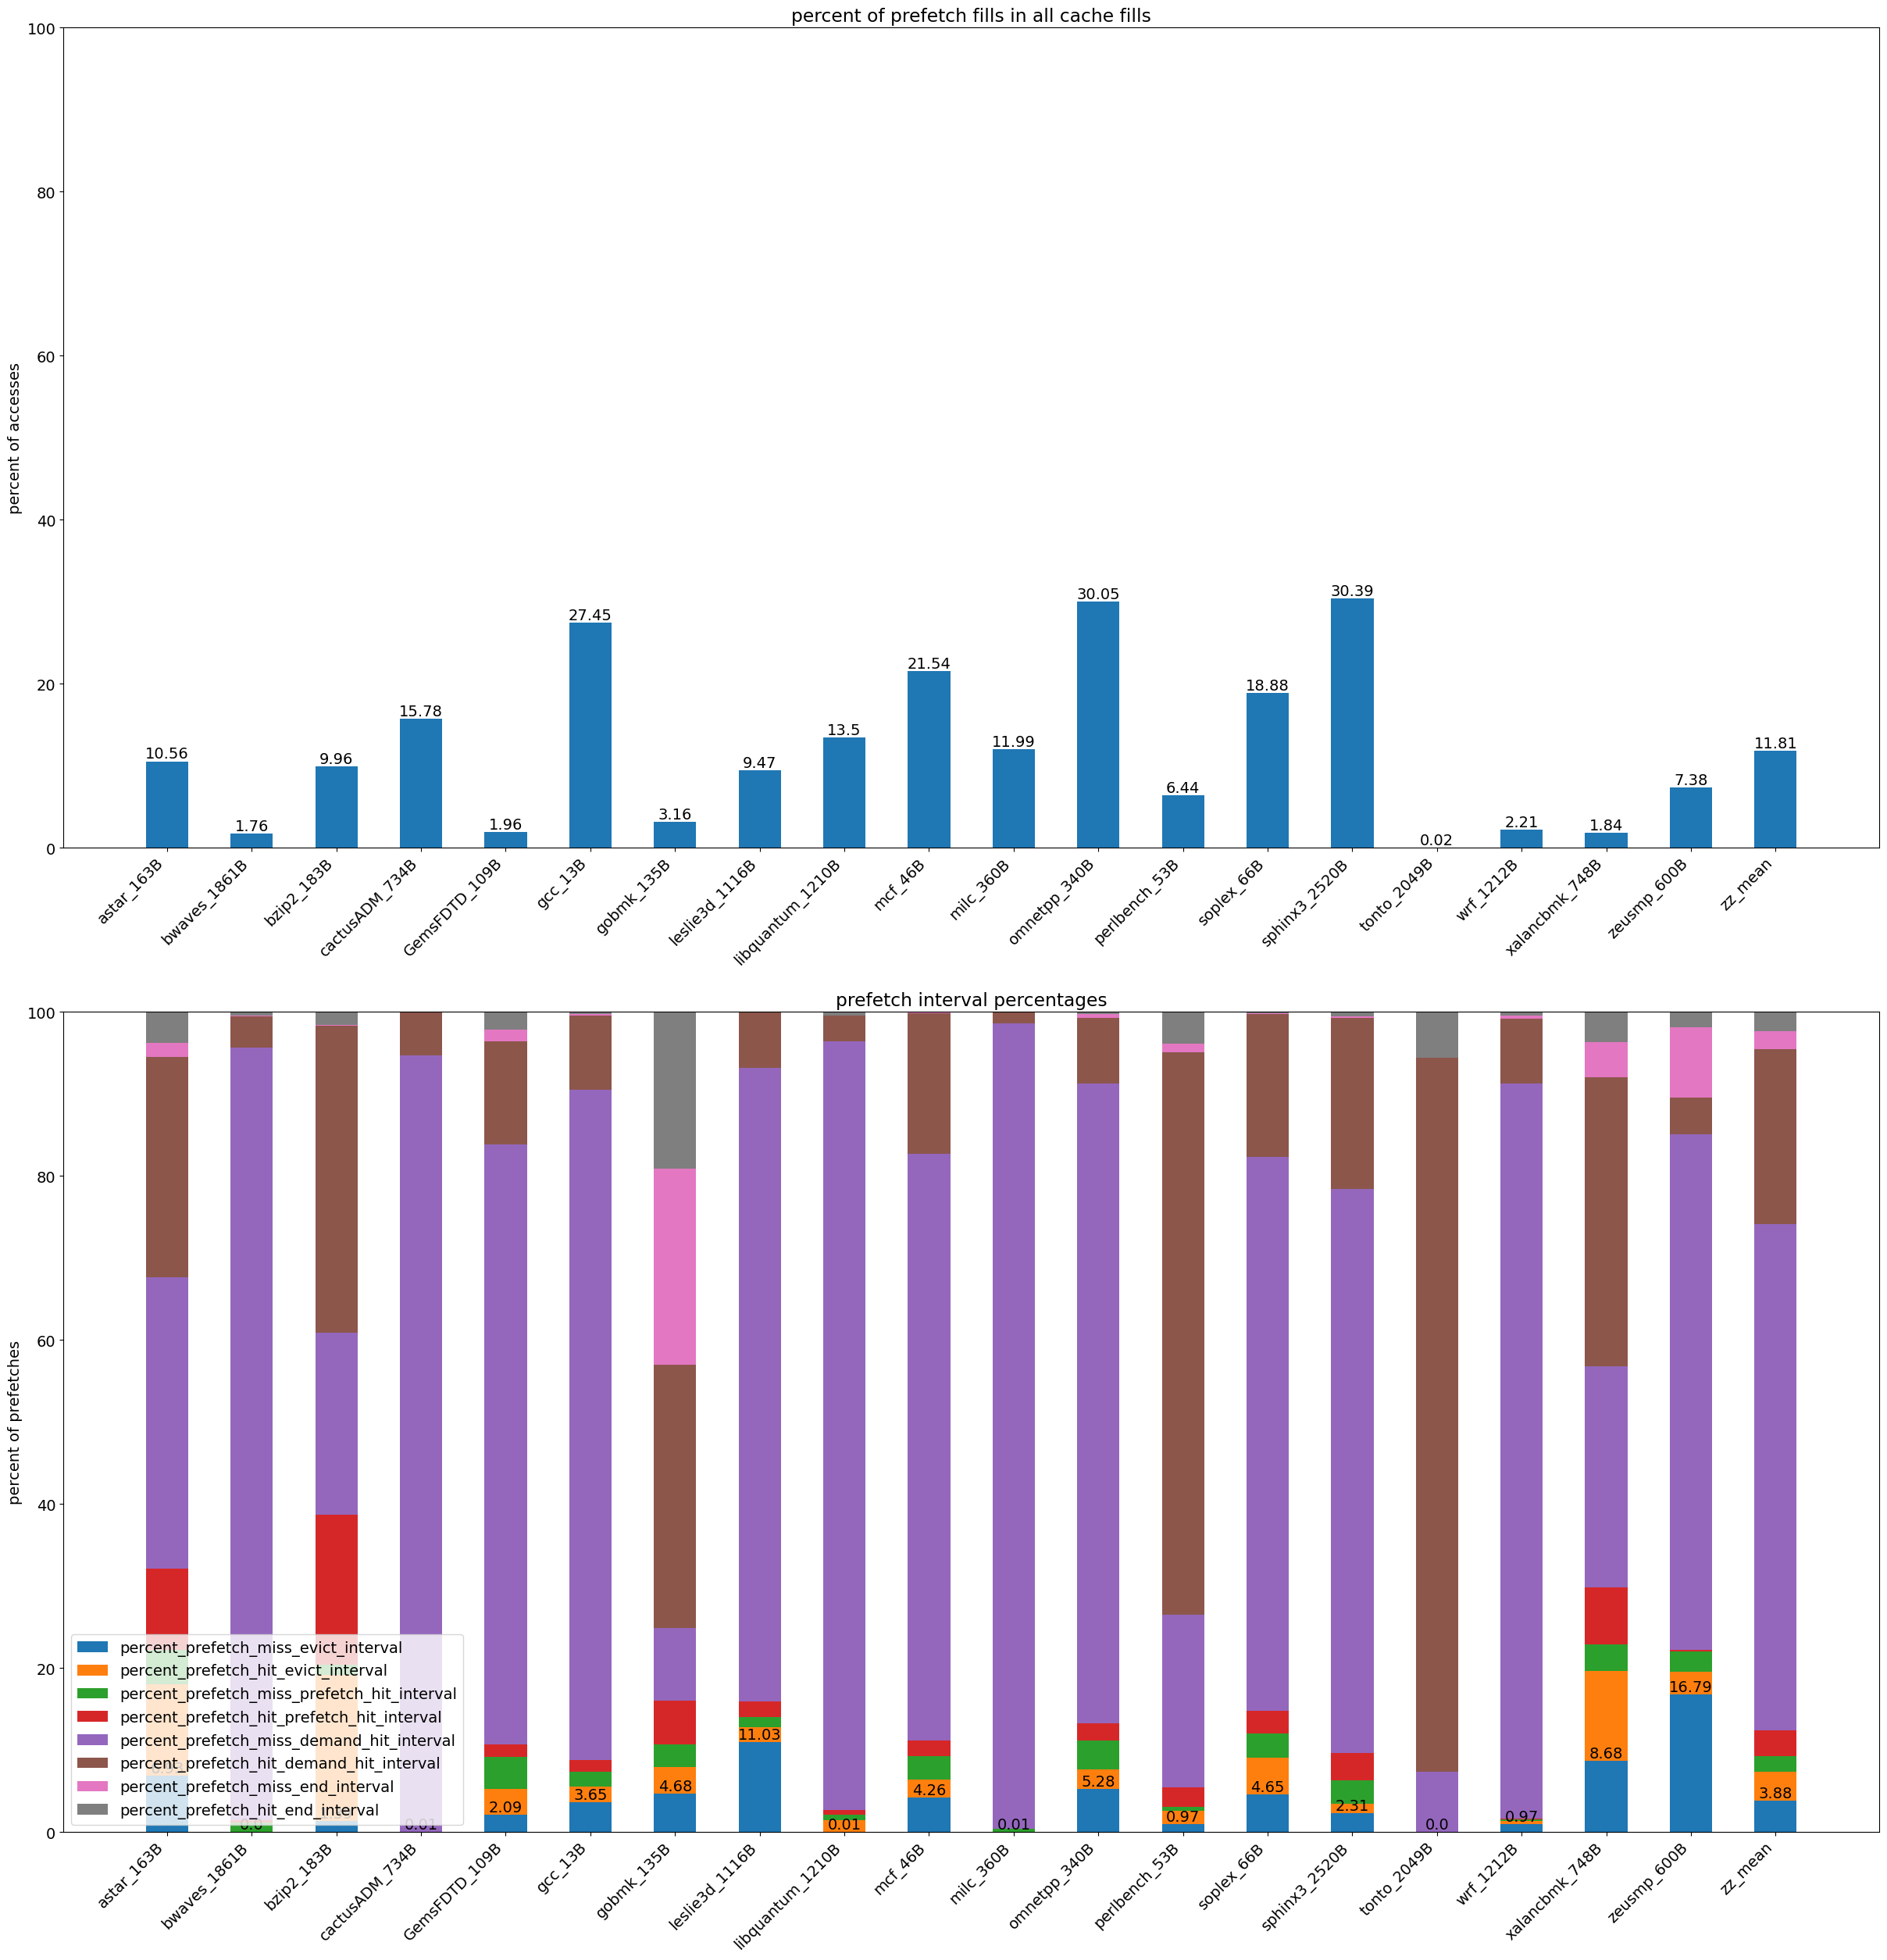

In [8]:
# Harmony with realistic ISB Prefetch Interval Use
# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_isb_updated_prefetch_interval'
trace_list = open('sim_list/traces_isb.txt', 'r')

(experiment_trace_files, traces) = get_experiment_traces(experiment, trace_list)

graph_prefetch_use(experiment, experiment_trace_files, traces)
plt.show()

### Analysis

The top graph shows that ISB issues significantly fewer prefetch fills compared to the Best Offset prefetcher. The second graph shows that ISB is highly accurate, with a lower bound for accuracy at about 80% on average. The lower bound for accuracy is calculated as the combined purple and brown bars (Pm - D and Ph - D intervals). On the other hand, the blue bars representing the Pm - E intervals are significantly lower than that of the Best Offset prefetcher, indicating that the lower bound estimate for prefetch traffic reduction is on average about 3.68% of all prefetch intervals.

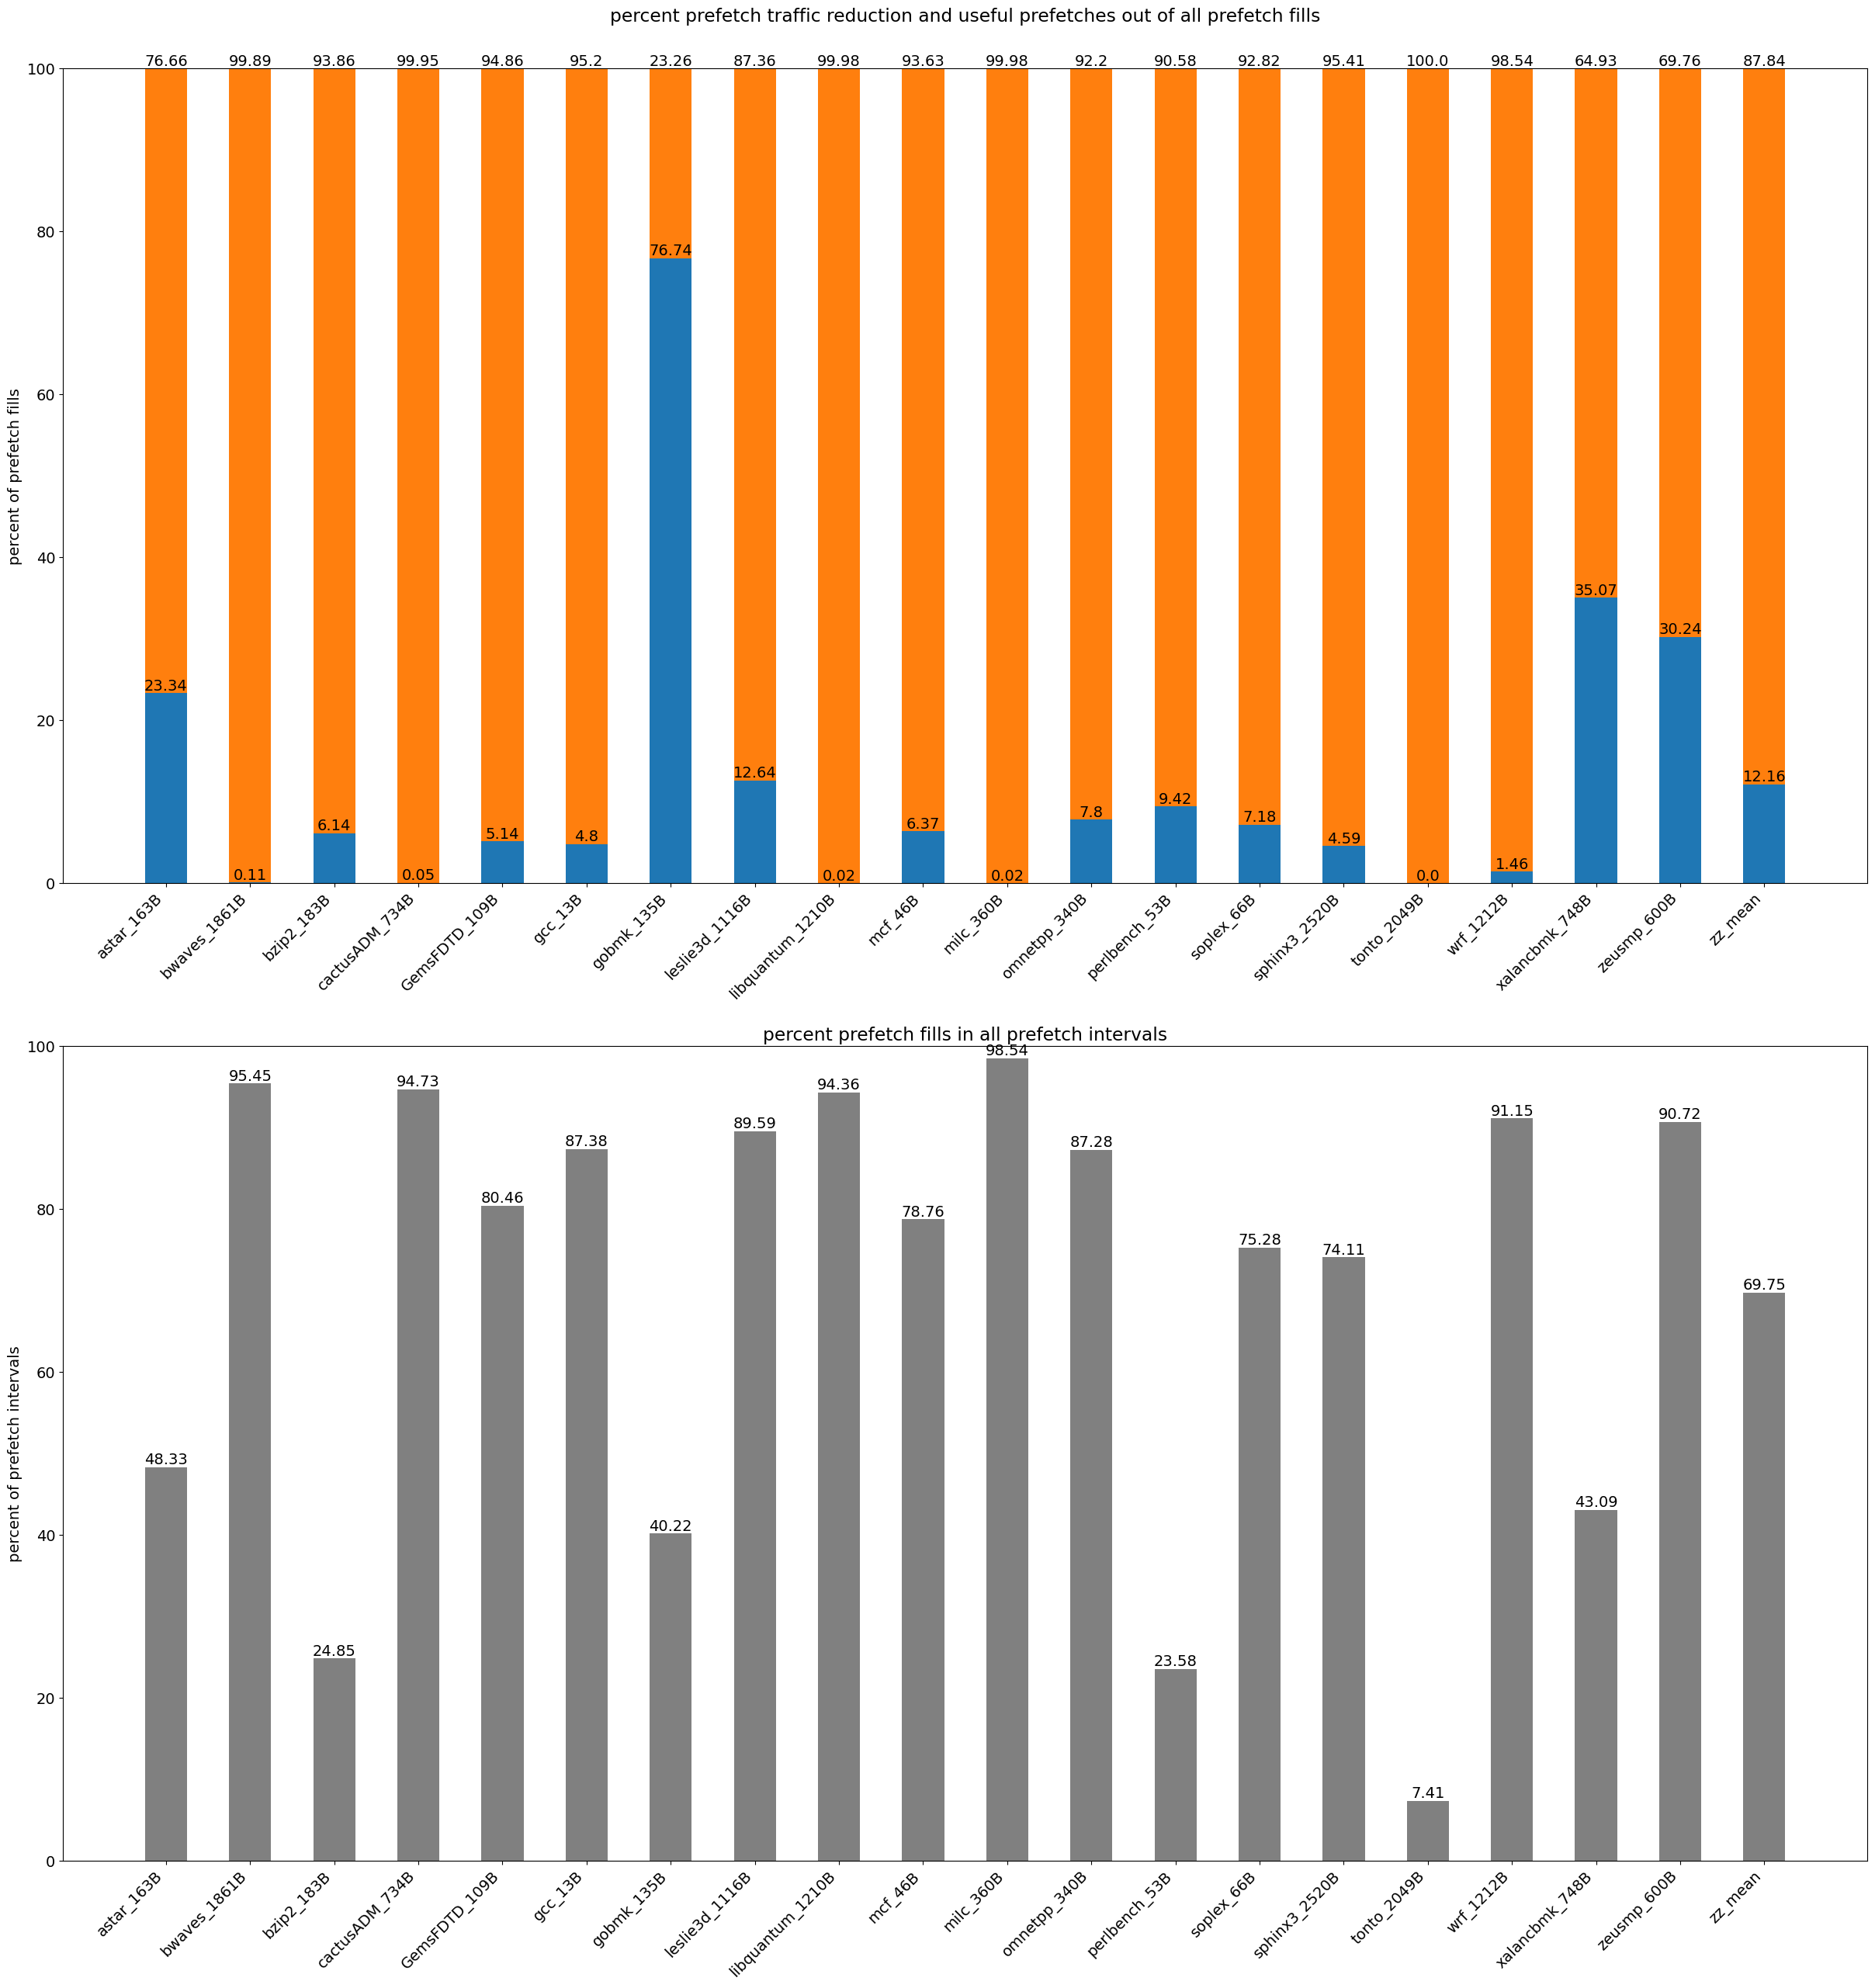

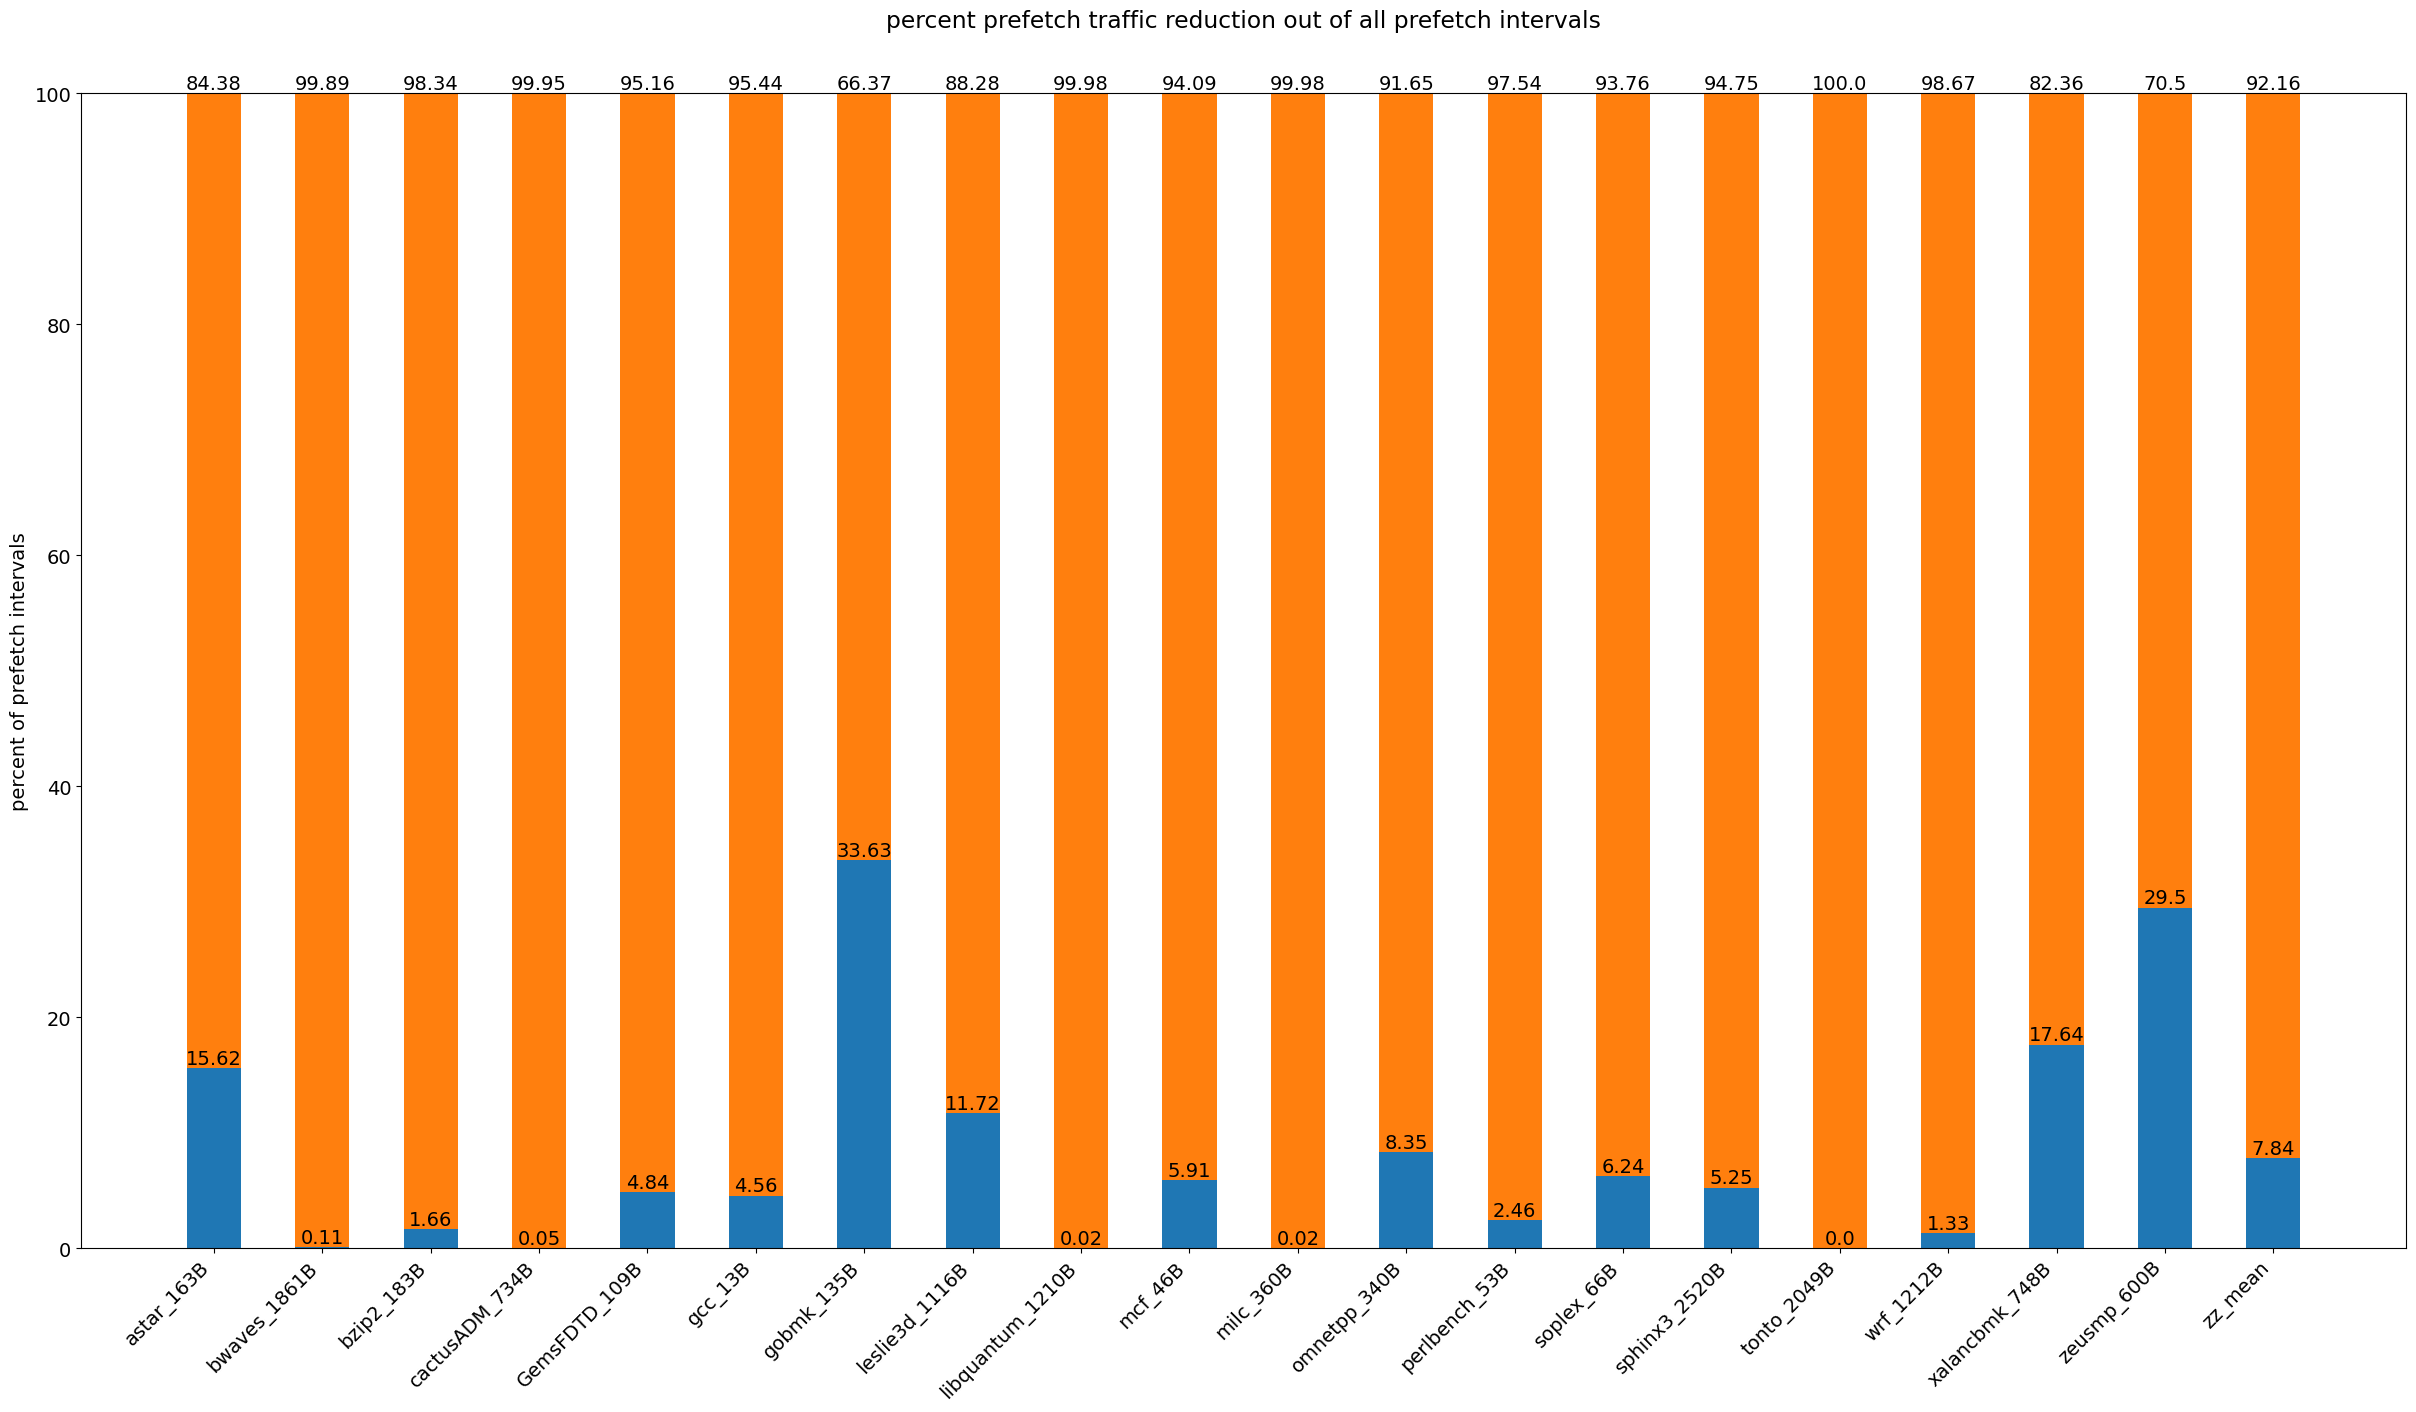

In [9]:
# Harmony with ISB Prefetch Traffic Reduction
graph_prefetch_traffic_reduction(experiment, experiment_trace_files, traces)
plt.show()

### Analysis

As expected, the ISB preetcher issues signficantly fewer useless prefetches. On average, about 7.84% of all prefetch intervals are useless prefetches that are counted as potential prefetch traffic reduction. On average, the ISB prefetcher is about 92.16% accurate on all issued prefetches, and about 87.4% accurate on all issued prefetch fills.